In [1]:
import pandas as pd
pd.set_option('display.max_rows', 15)

In [2]:
from zipline.pipeline import Pipeline, engine_from_files
from zipline.utils.tradingcalendar import trading_days

start_date = pd.Timestamp('2014-01-02', tz='UTC')
end_date = pd.Timestamp("2014-06-30", tz='UTC')
engine = engine_from_files(
    'data/equity_daily_bars.bcolz/',
    'data/adjustments.db',
    'data/assets.db',
    trading_days,
    warmup_assets=True,
)

Warmed up 29962 assets.


# Example: Less Simple Momentum
- Compute 30 and 90 day moving averages.
- Consider assets whose 30 day average is greater than 90 day average.
- Intuition is that assets with higher short averages are "on the way up".

In [3]:
from zipline.pipeline.data import USEquityPricing as USEP
from zipline.pipeline.factors import SimpleMovingAverage

# sma30 and sma90 are Factors.
# Factors represent computations producing numerical-valued outputs.
sma30 = SimpleMovingAverage(inputs=[USEP.close], window_length=30)
sma90 = SimpleMovingAverage(inputs=[USEP.close], window_length=90)

# Comparisons between Factors produce Filters.
# Filters represent computations producing boolean-valued outputs.
screen = (sma30 > sma90)

example0 = Pipeline(
    columns={"sma30": sma30, "sma90": sma90},
    screen=screen,
)
example0

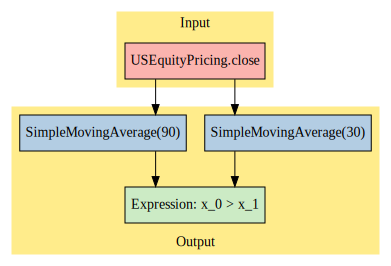

In [4]:
example0.show_graph('svg')

In [5]:
results0 = engine.run_pipeline(example0, start_date, end_date)
results0

sma30       sma90
2014-01-02 00:00:00+00:00 Equity(2 [AA])             9.669300    8.885178
                          Equity(21 [AAME])          4.015833    4.005022
                          Equity(24 [AAPL])        550.211467  514.120772
                          Equity(25 [AA_PR])        76.746038   76.029569
                          Equity(39 [DDC])          13.721000   13.254922
                          Equity(41 [ARCB])         33.207333   28.663605
                          Equity(52 [ABM])          27.691924   26.902632
...                                                       ...         ...
2014-06-30 00:00:00+00:00 Equity(46869 [ALDR])      14.684367   13.911694
                          Equity(46876 [TOUR])      15.629467   14.902457
                          Equity(46891 [AMH_PRC])   24.732495   24.715853
                          Equity(46896 [SB_PRC])    25.296433   25.283029
                          Equity(46910 [SFBS])      86.144667   86.023125
                          Equity(46918 [ZEN])       16.846667   16.734516
                          Equity(46920 [AGNC_B])    24.789700   24.787531

[626499 rows x 2 columns]

# Example: Less Simple Momentum
- Compute 30 and 90 day Volume-Weighted Average Price
- Rank assets by percent difference in 30-day VWAP vs 90-day VWAP.

In [6]:
from zipline.pipeline.factors import VWAP

vwap30 = VWAP(window_length=30)
vwap90 = VWAP(window_length=90)

# Arithmetic operations between Factors produce new Factors.
vwap_pct_change = ((vwap30 - vwap90) / vwap30)

# rank() is a method available on any Factor instance.
# It produces a new Factor containing the numerical rank of each
# asset after sorting the underyling Factor values.
vwap_pct_change_rank = vwap_pct_change.rank(ascending=False)

# top() is another method available on Factors.  It produces a Filter
# representing the top N assets sorted by the underlying Factor values.
top200 = vwap_pct_change.top(200)

example1 = Pipeline(
    columns={
        "rank": vwap_pct_change_rank,
        "pct_change": vwap_pct_change,
    },
    screen=top200,
)

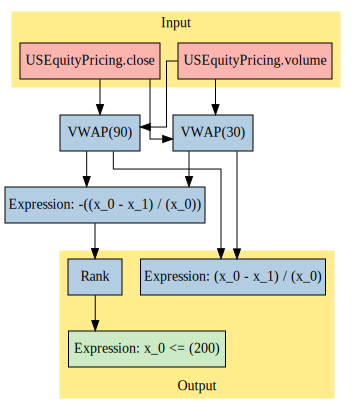

In [7]:
example1.show_graph()

In [8]:
engine.run_pipeline(example1, start_date, end_date)

pct_change  rank
2014-01-02 00:00:00+00:00 Equity(41 [ARCB])       0.147801   147
                          Equity(53 [ABMD])       0.138028   191
                          Equity(84 [ACET])       0.155196   113
                          Equity(273 [ALU])       0.147033   149
                          Equity(450 [CLFD])      0.154339   116
                          Equity(935 [NCS])       0.147258   148
                          Equity(1031 [BONT])     0.185019    45
...                                                    ...   ...
2014-06-30 00:00:00+00:00 Equity(46680 [TEDU])    0.116687   138
                          Equity(46722 [ADMS])    0.132853    77
                          Equity(46770 [TRIV])    0.129921    94
                          Equity(46771 [MC])      0.130185    93
                          Equity(46778 [VTL])     0.244516     5
                          Equity(46869 [ALDR])    0.118973   127
                          Equity(46876 [TOUR])    0.136723    67

[24800 rows x 2 columns]

# Example: Custom Factors and Masking

In [11]:
import numpy as np
from zipline.pipeline import CustomFactor


class MaxDrawdown(CustomFactor):
    """
    Factor computing the maximum drawdown 
    an asset has taken in the last N days.
    """
    inputs = [USEP.close]
    def compute(self, today, assets, out, closes):
        # The difference between each day and the max of all
        # earlier days in the period.
        drawdowns = fmax.accumulate(closes, axis=0) - closes
        drawdowns[isnan(drawdowns)] = np.NINF
        drawdown_ends = np.nanargmax(drawdowns, axis=0)

        # This is slow in pure Python.
        # Cython or Numba could accelerate this substantially.
        for i, end in enumerate(drawdown_ends):
            peak = nanmax(data[:end + 1, i])
            out[i] = (peak - data[end, i]) / data[end, i]

                    
maxdd_90 = MaxDrawdown(window_length=90)

# rank() takes an optional `mask` keyword, which can be passed a Filter
# to signify "Compute rank() only for assets for which the Filter 
# returned True.

masked_rank = vwap_pct_change.rank(mask=maxdd_90.bottom(200))
example2 = Pipeline(
    columns={
        'masked_rank': masked_rank
    },
    screen=maxdd_90.bottom(200),
)

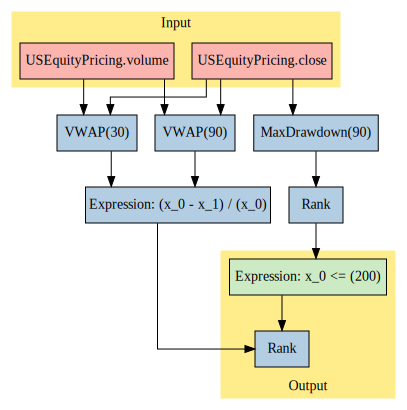

In [12]:
example2.show_graph('svg')

In [13]:
engine.run_pipeline(example1, start_date, end_date)

pct_change  rank
2014-01-02 00:00:00+00:00 Equity(41 [ARCB])       0.147801   147
                          Equity(53 [ABMD])       0.138028   191
                          Equity(84 [ACET])       0.155196   113
                          Equity(273 [ALU])       0.147033   149
                          Equity(450 [CLFD])      0.154339   116
                          Equity(935 [NCS])       0.147258   148
                          Equity(1031 [BONT])     0.185019    45
...                                                    ...   ...
2014-06-30 00:00:00+00:00 Equity(46680 [TEDU])    0.116687   138
                          Equity(46722 [ADMS])    0.132853    77
                          Equity(46770 [TRIV])    0.129921    94
                          Equity(46771 [MC])      0.130185    93
                          Equity(46778 [VTL])     0.244516     5
                          Equity(46869 [ALDR])    0.118973   127
                          Equity(46876 [TOUR])    0.136723    67

[24800 rows x 2 columns]